<a href="https://colab.research.google.com/github/MatP-DS/MasterThesis/blob/main/bi_lstm_full_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow tensorflow-addons --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 30.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
# Build and train a simple LSTM model for time-series deforestation classification
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset from Drive
X = np.load("/content/drive/MyDrive/MasterThesis/02_preprocessed_data/X_time_series_full.npz")["X"]  # shape: (n, 48, 11)
y = np.load("/content/drive/MyDrive/MasterThesis/02_preprocessed_data/y_labels_2023_fromstack.npz")["y"]       # shape: (n,)


In [ ]:
# Only keep samples where ground truth is either 0 (no loss) or 1 (loss)
valid_mask = (y == 0) | (y == 1)
X = X[valid_mask]
y = y[valid_mask]

# Replace missing values (NaNs) in feature array with 0.
# This is a simple, neutral fill strategy
X = np.nan_to_num(X)

# Time-series and feature dimension extraction
n_timesteps, n_features = X.shape[1], X.shape[2]

# Flatten time dimension to scale all feature values across all time steps
# Shape changes from (n_samples, time, features) → (n_samples × time, features)
X_reshaped = X.reshape(-1, n_features)


# StandardScaler: transforms each band/index to mean=0, std=1
scaler = StandardScaler()
# Reshape back to original time-series structure (n_samples, time, features)
X_scaled = scaler.fit_transform(X_reshaped).reshape(-1, n_timesteps, n_features)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Automatically compute class weights to penalize the model for class imbalance
# does not work well
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights_array))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, Bidirectional

# Sequential model: inputs → Bi-LSTM → dropout → Dense (32 units) → dropout → Dense (1 output)

model = Sequential([
    Input(shape=(n_timesteps, n_features)),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile model with binary cross-entropy loss (used for binary classification)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train model
# Timer
start = time.time()

history = model.fit(
    X_train, y_train,
    validation_split=0.2, # Use 20% of training data for validation (not test set!)
    epochs=30,
    batch_size=256,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)
train_time = time.time() - start

Epoch 1/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9987 - loss: 0.0086 - val_accuracy: 0.9996 - val_loss: 0.0018
Epoch 2/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.9996 - val_loss: 0.0017
Epoch 3/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.9996 - val_loss: 0.0015
Epoch 4/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 0.9996 - val_loss: 0.0014
Epoch 5/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.9996 - val_loss: 0.0014
Epoch 6/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9995 - loss: 0.0016 - val_accuracy: 0.9996 - val_loss: 0.0013
Epoch 7/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9996 - val_loss: 0.0015
Epoch 8/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9996 -

In [ ]:
# Predict probabilities on unseen test data
y_pred_prob = model.predict(X_test)

# Apply a threshold (default = 0.3) to convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.3).astype(int)


2917/2917 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


In [ ]:
print(f"Min prob: {y_pred_prob.min():.4f}, Max prob: {y_pred_prob.max():.4f}")

Min prob: 0.0000, Max prob: 0.9968


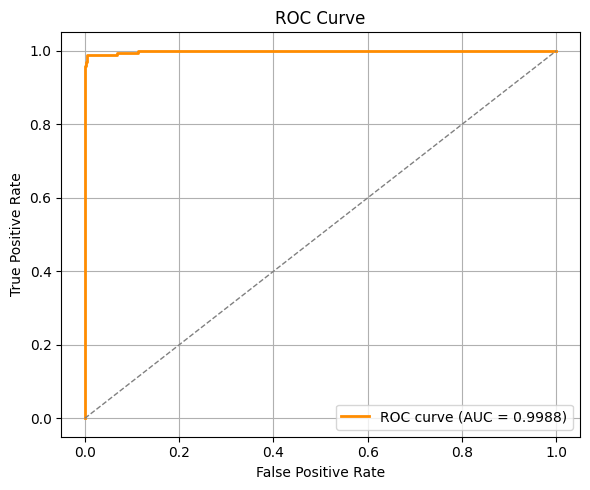

🔎 Best threshold: 0.55 — F1-score: 0.8908


In [ ]:
from sklearn.metrics import roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import numpy as np

# ROC Curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Threshold optimization for F1-score
thresholds = np.arange(0.3, 0.91, 0.05)
f1_scores = [f1_score(y_test, y_pred_prob > t) for t in thresholds]

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"🔎 Best threshold: {best_threshold:.2f} — F1-score: {best_f1:.4f}")

In [ ]:
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1 (loss)": f1_score(y_test, y_pred),
    "Recall (loss)": recall_score(y_test, y_pred),
    "Precision (loss)": precision_score(y_test, y_pred),
    "Training Time (s)": train_time
}
cm = confusion_matrix(y_test, y_pred)
metrics_df = pd.DataFrame([metrics])
cm_df = pd.DataFrame(cm, index=["No Loss (0)", "Loss (1)"], columns=["Predicted 0", "Predicted 1"])

metrics_df, cm_df

(   Accuracy  F1 (loss)  Recall (loss)  Precision (loss)  Training Time (s)
 0  0.999539   0.881543       0.941176          0.829016         171.897316,
              Predicted 0  Predicted 1
 No Loss (0)        93139           33
 Loss (1)              10          160)

In [ ]:
def save_model_results_extended(model_name, model, metrics_df, cm_df=None, folder="/content/drive/MyDrive/MasterThesis/04_results/metrics"):
    """
    Save model evaluation results including metrics, hyperparameters, and confusion matrix.

    Parameters:
    - model_name: str, name of the model (e.g., "xgboost", "random_forest")
    - model: trained model object with `.get_params()` or `.__dict__`
    - metrics_df: pd.DataFrame with one row of evaluation metrics
    - cm_df: pd.DataFrame with confusion matrix (optional)
    - folder: target folder path
    """
    import os
    import json
    from datetime import datetime

    os.makedirs(folder, exist_ok=True)

    # Timestamp for versioned output
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_filename = f"{model_name}_metrics_{timestamp}"

    # Save metrics CSV and JSON
    metrics_path_csv = os.path.join(folder, f"{base_filename}.csv")
    metrics_df.to_csv(metrics_path_csv, index=False)

    # Extract model parameters
    try:
        params = model.get_params()
    except AttributeError:
        # fallback for native lightgbm or xgboost booster objects
        params = model.__dict__

    # Combine everything into one JSON log
    log_dict = {
        "model_name": model_name,
        "timestamp": timestamp,
        "metrics": metrics_df.to_dict(orient="records")[0],
        "hyperparameters": {k: str(v) for k, v in params.items()}
    }

    # Save full metadata log as JSON
    metrics_path_json = os.path.join(folder, f"{base_filename}.json")
    with open(metrics_path_json, 'w') as f:
        json.dump(log_dict, f, indent=4)

    # Save confusion matrix separately if given
    cm_path_csv = None
    if cm_df is not None:
        cm_path_csv = os.path.join(folder, f"{base_filename}_confusion_matrix.csv")
        cm_df.to_csv(cm_path_csv)

    return {
        "csv": metrics_path_csv,
        "json": metrics_path_json,
        "confusion_matrix": cm_path_csv
    }

In [ ]:
# Example usage:
save_model_results_extended("bi-lstm_full-features_thresh30", model, metrics_df, cm_df)

{'csv': '/content/drive/MyDrive/MasterThesis/04_results/metrics/bi-lstm_full-features_thresh30_metrics_20250521_053109.csv',
 'json': '/content/drive/MyDrive/MasterThesis/04_results/metrics/bi-lstm_full-features_thresh30_metrics_20250521_053109.json',
 'confusion_matrix': '/content/drive/MyDrive/MasterThesis/04_results/metrics/bi-lstm_full-features_thresh30_metrics_20250521_053109_confusion_matrix.csv'}